In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from torch.optim import Adam
from tqdm import tqdm
import torch
import dataset_utils as data
import utils as utils

import random
import numpy as np

In [2]:
#%% 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

In [3]:
base_dir = "/home/mlsnrs/data/data/lff/ai-lab/lab3/"
data_dir = base_dir + "../../data/"
prefix = "lstm_att_glove"

if not os.path.exists(f"model/{prefix}"):
    os.makedirs(f"model/{prefix}")

lr = 1e-3
decay = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size= 64
num_workers = 4
num_epochs = 50

In [4]:
# Load dataset
# train_set_imdb = data.ImdbDatasetLoader(f"{data_dir}/aclImdb/train")
data_weight = 0.8
train_set_imdb = None
# 
train_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/train.data")
dev_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/valid.data")

# building vocabulary
vocab, idx_to_word = data.build_vocab([
    train_set_imdb if train_set_imdb is not None else []
    , train_set, dev_set])

# word->idx
if train_set_imdb is not None:
    train_set_imdb.convert_word_to_idx(vocab)
train_set.convert_word_to_idx(vocab)
dev_set.convert_word_to_idx(vocab)

# samples: 8596
# samples: 1000


In [5]:
# pretrain words vector
import torchtext.vocab as Vocab

glove_vocab = Vocab.GloVe(name='6B', dim=100, cache=os.path.join(data_dir+"/fudan_nlp/", "glove"))
print(len(glove_vocab.stoi)) # 400000
print(glove_vocab[0].shape)

vocab_weights = data.load_pretrained_embedding(vocab.keys(), glove_vocab)

400000
torch.Size([100])
There are 736 oov words.
['<pad>', '<unk>', '', 'eckstraordinarily', 'cletis', 'swordfights', 'completist', '�the', 'slappingly', 'clichand', 'gantzes', 'surfacey', 'reeboir', 'recurre', 'clich�s', 'g�nero', 'actuaci�n', 'perdona', 'gui�n', 'guessable', 'aceitou', 'continua��o', 'sa�do', 'pesquerdo', 'aqueles', 'decidiram', 'assistir', 'tamb�m', 'unimpressively', 'aborbing', 'histo', 'third�emotionally', 'coriat', 'miscasts', 'likableness', 'contando', 'premissa', 'mergulha', 'culminando', 'desfecho', 'certamente', 'mem�ria', 'enrapturing', 'clich�d', 'nonjudgmentally', 'bottomlessly', 'travil', 'clutchy', 'pistoled', 'vocsinta', 'necessidade', 't�rmino', 'proje��o', 'n�o', 'preocupe', 'ningu�m', 'lhe', 'enviarpenas', 'simbolizando', 'covardia', 'birot', 'wifty', 'wisegirls', 'nrelentingly', 'jirhubac', 'rintars', 'gabbiest', 'nonethnic', 'crummles', 'almod�var', 'logra', 'entra�able', 'compasi�n', 'comprensi�n', 'inolvidable', 'shimmeringly', 'schneidermeister

In [6]:
from lstm_att import LSTM_Attention


model =LSTM_Attention(
    vocab_size=len(vocab),                
    embedding_dim=100, 
    hidden_dim=256, n_layers=1, num_class=2,
    pretrain_weights=vocab_weights, dropout=0.5)

print(model)

LSTM_Attention(
  (embedding): Embedding(17540, 100)
  (constant_embedding): Embedding(17540, 100)
  (rnn): LSTM(200, 256, batch_first=True, bidirectional=True)
  (W_Q): Linear(in_features=512, out_features=512, bias=False)
  (W_K): Linear(in_features=512, out_features=512, bias=False)
  (W_V): Linear(in_features=512, out_features=512, bias=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (loss_ce): CrossEntropyLoss()
)


In [7]:
model.to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=decay) 


# train
loss_tr_his , acc_tr_his = [],[]
loss_dev_his , acc_dev_his = [],[]

the_best = {'eval_acc': 100,
            'model_path':''}

In [8]:
import utils as utils
loss_aux_his , acc_aux_his = [],[]

In [9]:
# train_set = dev_set
for epo in range(num_epochs): 
    # train once in imdb if not none
    # train once in fudan dataset
    if train_set_imdb is not None:
        (batch_avg_loss, batch_avg_acc),(
            l_,a_) = utils.train_batch_cross_domain(
            model, train_set, train_set_imdb, batch_size, num_workers, device,
            optimizer, weighted=data_weight)
            
        loss_aux_his.append(l_)
        acc_aux_his.append(a_)
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)

    else:
        batch_avg_loss, batch_avg_acc = utils.train_batch(
            model, train_set, batch_size, num_workers, device,
            optimizer)    
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)


    # eval once
    eval_loss, eval_acc, _, __ = utils.eval(model, dev_set, batch_size, num_workers, device)
    loss_dev_his.append(eval_loss)
    acc_dev_his.append(eval_acc)

    print(f"epoch[{epo}]  tr_loss: {batch_avg_loss}   tr_acc: {batch_avg_acc}   eval_loss: {eval_loss}   eval_acc: {eval_acc}")

    # save
    if eval_acc >= max(acc_dev_his):
        the_best['model_path'] =  f"model/{prefix}_best.pth"
        the_best['eval_acc'] =  eval_acc
        
        torch.save(model, the_best['model_path'])
        
        print(f"ckp: save as { the_best['model_path'] }, acc {the_best['eval_acc']}")

100%|██████████| 135/135 [00:02<00:00, 57.63it/s]


epoch[0]  tr_loss: 0.8151856180447251   tr_acc: 0.6326198231735691   eval_loss: 0.599067485332489   eval_acc: 0.707
ckp: save as model/lstm_att_glove_best.pth, acc 0.707


100%|██████████| 135/135 [00:01<00:00, 68.22it/s]


epoch[1]  tr_loss: 0.5865792743305662   tr_acc: 0.6981154025127967   eval_loss: 0.5599413951237996   eval_acc: 0.738
ckp: save as model/lstm_att_glove_best.pth, acc 0.738


100%|██████████| 135/135 [00:02<00:00, 66.71it/s]


epoch[2]  tr_loss: 0.5560183529533557   tr_acc: 0.7209167054443928   eval_loss: 0.5372909029324849   eval_acc: 0.743
ckp: save as model/lstm_att_glove_best.pth, acc 0.743


100%|██████████| 135/135 [00:01<00:00, 73.41it/s]


epoch[3]  tr_loss: 0.5337214485478046   tr_acc: 0.7383666821777571   eval_loss: 0.5226042668024699   eval_acc: 0.756
ckp: save as model/lstm_att_glove_best.pth, acc 0.756


100%|██████████| 135/135 [00:01<00:00, 71.43it/s]


epoch[4]  tr_loss: 0.5224190610113428   tr_acc: 0.7395300139599814   eval_loss: 0.5135171473026275   eval_acc: 0.763
ckp: save as model/lstm_att_glove_best.pth, acc 0.763


100%|██████████| 135/135 [00:01<00:00, 69.21it/s]


epoch[5]  tr_loss: 0.5167798273154159   tr_acc: 0.7417403443462075   eval_loss: 0.5095924496650696   eval_acc: 0.756


100%|██████████| 135/135 [00:01<00:00, 67.66it/s]


epoch[6]  tr_loss: 0.5105187892913818   tr_acc: 0.7466263378315495   eval_loss: 0.5030270338058471   eval_acc: 0.759


100%|██████████| 135/135 [00:01<00:00, 67.95it/s]


epoch[7]  tr_loss: 0.4882577657699585   tr_acc: 0.7594229874360168   eval_loss: 0.4759969929854075   eval_acc: 0.782
ckp: save as model/lstm_att_glove_best.pth, acc 0.782


100%|██████████| 135/135 [00:01<00:00, 70.46it/s]


epoch[8]  tr_loss: 0.4831533102846857   tr_acc: 0.7684969753373662   eval_loss: 0.4766384879748026   eval_acc: 0.771


100%|██████████| 135/135 [00:01<00:00, 72.77it/s]


epoch[9]  tr_loss: 0.47030306596364546   tr_acc: 0.7733829688227082   eval_loss: 0.4791646997133891   eval_acc: 0.775


100%|██████████| 135/135 [00:01<00:00, 73.58it/s]


epoch[10]  tr_loss: 0.4725184489541979   tr_acc: 0.7748953001395998   eval_loss: 0.4593046168486277   eval_acc: 0.794
ckp: save as model/lstm_att_glove_best.pth, acc 0.794


100%|██████████| 135/135 [00:01<00:00, 69.83it/s]


epoch[11]  tr_loss: 0.4570547213305288   tr_acc: 0.783620288506282   eval_loss: 0.45484466751416525   eval_acc: 0.795
ckp: save as model/lstm_att_glove_best.pth, acc 0.795


100%|██████████| 135/135 [00:01<00:00, 70.82it/s]


epoch[12]  tr_loss: 0.45912428667296223   tr_acc: 0.7809446254071661   eval_loss: 0.4504652778307597   eval_acc: 0.791


100%|██████████| 135/135 [00:02<00:00, 66.03it/s]


epoch[13]  tr_loss: 0.438556747872438   tr_acc: 0.7914146114471847   eval_loss: 0.4398469587167104   eval_acc: 0.805
ckp: save as model/lstm_att_glove_best.pth, acc 0.805


100%|██████████| 135/135 [00:01<00:00, 73.69it/s]


epoch[14]  tr_loss: 0.44792114198207855   tr_acc: 0.7902512796649604   eval_loss: 0.44939369161923726   eval_acc: 0.791


100%|██████████| 135/135 [00:02<00:00, 65.79it/s]


epoch[15]  tr_loss: 0.4291716389246841   tr_acc: 0.7971149371800837   eval_loss: 0.447404158115387   eval_acc: 0.798


100%|██████████| 135/135 [00:02<00:00, 66.63it/s]


epoch[16]  tr_loss: 0.4137505206154354   tr_acc: 0.8065379246161005   eval_loss: 0.43987489144007363   eval_acc: 0.805
ckp: save as model/lstm_att_glove_best.pth, acc 0.805


100%|██████████| 135/135 [00:01<00:00, 74.03it/s]


epoch[17]  tr_loss: 0.41283261642527225   tr_acc: 0.8085155886458818   eval_loss: 0.48672678669293723   eval_acc: 0.79


100%|██████████| 135/135 [00:01<00:00, 71.91it/s]


epoch[18]  tr_loss: 0.4007444808732218   tr_acc: 0.8138669148441136   eval_loss: 0.44320247173309324   eval_acc: 0.81
ckp: save as model/lstm_att_glove_best.pth, acc 0.81


100%|██████████| 135/135 [00:01<00:00, 72.15it/s]


epoch[19]  tr_loss: 0.3845124757334368   tr_acc: 0.8285248953001396   eval_loss: 0.44704795877138775   eval_acc: 0.803


100%|██████████| 135/135 [00:01<00:00, 70.97it/s]


epoch[20]  tr_loss: 0.37917964093720735   tr_acc: 0.8293392275476966   eval_loss: 0.4615087350209554   eval_acc: 0.801


100%|██████████| 135/135 [00:01<00:00, 70.42it/s]


epoch[21]  tr_loss: 0.3712345614139713   tr_acc: 0.8348068869241507   eval_loss: 0.43925876220067345   eval_acc: 0.798


100%|██████████| 135/135 [00:01<00:00, 67.87it/s]


epoch[22]  tr_loss: 0.36832837549163333   tr_acc: 0.8342252210330386   eval_loss: 0.4503072122732798   eval_acc: 0.8


100%|██████████| 135/135 [00:01<00:00, 70.82it/s]


epoch[23]  tr_loss: 0.35438250594619497   tr_acc: 0.8415542112610517   eval_loss: 0.4631339053312937   eval_acc: 0.811
ckp: save as model/lstm_att_glove_best.pth, acc 0.811


100%|██████████| 135/135 [00:02<00:00, 65.96it/s]


epoch[24]  tr_loss: 0.3402097786762821   tr_acc: 0.8480688692415077   eval_loss: 0.4802158296108246   eval_acc: 0.807


100%|██████████| 135/135 [00:02<00:00, 67.10it/s]


epoch[25]  tr_loss: 0.3230460186058016   tr_acc: 0.8597021870637506   eval_loss: 0.45688366889953613   eval_acc: 0.803


100%|██████████| 135/135 [00:01<00:00, 68.45it/s]


epoch[26]  tr_loss: 0.32351597898931644   tr_acc: 0.8591205211726385   eval_loss: 0.4354052424430847   eval_acc: 0.813
ckp: save as model/lstm_att_glove_best.pth, acc 0.813


100%|██████████| 135/135 [00:01<00:00, 69.20it/s]


epoch[27]  tr_loss: 0.3124375839286776   tr_acc: 0.8636575151233131   eval_loss: 0.46927875677744546   eval_acc: 0.809


100%|██████████| 135/135 [00:01<00:00, 69.36it/s]


epoch[28]  tr_loss: 0.29582119026958054   tr_acc: 0.8736621684504421   eval_loss: 0.49691194891929624   eval_acc: 0.809


100%|██████████| 135/135 [00:01<00:00, 73.74it/s]


epoch[29]  tr_loss: 0.2921997800246993   tr_acc: 0.8729641693811075   eval_loss: 0.5043756624062856   eval_acc: 0.811


100%|██████████| 135/135 [00:01<00:00, 67.89it/s]


epoch[30]  tr_loss: 0.28468497319897607   tr_acc: 0.8762214983713354   eval_loss: 0.5000539461771647   eval_acc: 0.813
ckp: save as model/lstm_att_glove_best.pth, acc 0.813


100%|██████████| 135/135 [00:02<00:00, 63.83it/s]


epoch[31]  tr_loss: 0.27471426162701934   tr_acc: 0.8806421591437879   eval_loss: 0.46331828633944194   eval_acc: 0.81


100%|██████████| 135/135 [00:01<00:00, 71.40it/s]


epoch[32]  tr_loss: 0.26097737897687884   tr_acc: 0.8908794788273615   eval_loss: 0.5368066827456156   eval_acc: 0.802


100%|██████████| 135/135 [00:01<00:00, 69.34it/s]


epoch[33]  tr_loss: 0.25662201726392136   tr_acc: 0.892624476500698   eval_loss: 0.5441633919874828   eval_acc: 0.803


100%|██████████| 135/135 [00:01<00:00, 71.08it/s]


epoch[34]  tr_loss: 0.2487424841678854   tr_acc: 0.8955328059562587   eval_loss: 0.49592349529266355   eval_acc: 0.809


100%|██████████| 135/135 [00:01<00:00, 71.84it/s]


epoch[35]  tr_loss: 0.24106813427894863   tr_acc: 0.8956491391344812   eval_loss: 0.4922713061173757   eval_acc: 0.793


100%|██████████| 135/135 [00:01<00:00, 68.02it/s]


epoch[36]  tr_loss: 0.22883354644499607   tr_acc: 0.9053047929269428   eval_loss: 0.5755564014116923   eval_acc: 0.803


100%|██████████| 135/135 [00:02<00:00, 63.03it/s]


epoch[37]  tr_loss: 0.22293132304478047   tr_acc: 0.905886458818055   eval_loss: 0.530249148607254   eval_acc: 0.815
ckp: save as model/lstm_att_glove_best.pth, acc 0.815


100%|██████████| 135/135 [00:01<00:00, 74.06it/s]


epoch[38]  tr_loss: 0.21597314336851461   tr_acc: 0.9084457887389483   eval_loss: 0.545483789841334   eval_acc: 0.804


100%|██████████| 135/135 [00:01<00:00, 68.79it/s]


epoch[39]  tr_loss: 0.20738054039095766   tr_acc: 0.9128664495114006   eval_loss: 0.5240857283274333   eval_acc: 0.814


100%|██████████| 135/135 [00:01<00:00, 67.55it/s]


epoch[40]  tr_loss: 0.20137998828692222   tr_acc: 0.9177524429967426   eval_loss: 0.6399238228797912   eval_acc: 0.798


100%|██████████| 135/135 [00:01<00:00, 68.75it/s]


epoch[41]  tr_loss: 0.1909084330076602   tr_acc: 0.9212424383434156   eval_loss: 0.5732660830020905   eval_acc: 0.807


100%|██████████| 135/135 [00:02<00:00, 66.78it/s]


epoch[42]  tr_loss: 0.1957440236166342   tr_acc: 0.9218241042345277   eval_loss: 0.534556794166565   eval_acc: 0.808


100%|██████████| 135/135 [00:01<00:00, 71.57it/s]


epoch[43]  tr_loss: 0.18779477595226535   tr_acc: 0.9275244299674267   eval_loss: 0.6350668728351593   eval_acc: 0.799


100%|██████████| 135/135 [00:01<00:00, 69.59it/s]


epoch[44]  tr_loss: 0.17373308303084836   tr_acc: 0.9288040949278734   eval_loss: 0.585989135503769   eval_acc: 0.807


100%|██████████| 135/135 [00:01<00:00, 70.56it/s]


epoch[45]  tr_loss: 0.1756615127200511   tr_acc: 0.9315960912052117   eval_loss: 0.6244219064712524   eval_acc: 0.803


100%|██████████| 135/135 [00:02<00:00, 66.33it/s]


epoch[46]  tr_loss: 0.15988081707549628   tr_acc: 0.9338064215914379   eval_loss: 0.6581521213054657   eval_acc: 0.814


100%|██████████| 135/135 [00:01<00:00, 70.73it/s]


epoch[47]  tr_loss: 0.16728630497940442   tr_acc: 0.9333410888785482   eval_loss: 0.8010193367799123   eval_acc: 0.793


100%|██████████| 135/135 [00:01<00:00, 70.82it/s]


epoch[48]  tr_loss: 0.1692498557881188   tr_acc: 0.9318287575616566   eval_loss: 0.6047169327735901   eval_acc: 0.808


100%|██████████| 135/135 [00:01<00:00, 68.89it/s]


epoch[49]  tr_loss: 0.15921041035830086   tr_acc: 0.9374127501163332   eval_loss: 0.6865064372618993   eval_acc: 0.802


In [10]:
def test_and_write(_data_iter, type="test"):
    preds= []

    for step, _batch in tqdm(enumerate(_data_iter)):
        model.eval()
        x,y=_batch
        with torch.no_grad():
            loss, pred = model(x.to(device), y.to(device))
            pred = pred.detach().cpu().numpy().tolist()
            preds.extend(pred)

    print(f'# {type} pred:', preds)

    with open(f'model/{prefix}/{type}_{len(loss_tr_his)}_res.txt',encoding="utf-8", mode='w') as f:
        for pred in preds:
            f.write("positive" if pred==1 else 'negative')
            f.write('\n')


## load the best model
model = torch.load(the_best['model_path'])


## 写出test结果到txt
test_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/test.data",test=True)

test_set.convert_word_to_idx(vocab)

test_data_iter=test_set.get_sequential_iter(batch_size, num_workers)
test_and_write(test_data_iter,type="test")

dev_data_iter= dev_set.get_sequential_iter(batch_size, num_workers)
test_and_write(dev_data_iter,type="valid")

# samples: 1066


17it [00:00, 96.05it/s]

# test pred: [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,


16it [00:00, 95.61it/s]

# valid pred: [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_(losses:dict, acces:dict, save=None):
    num_fig = 2
    plt.figure(num_fig, figsize=(8, 8))
    plt.grid(True)
    
    plt.subplot(num_fig, 1, 1)

    data_f = pd.DataFrame(losses)
    sns.scatterplot(data=data_f)


    plt.subplot(num_fig, 1, 2)
    data_f = pd.DataFrame(acces)
    sns.scatterplot(data=data_f)
    
    plt.savefig(save)

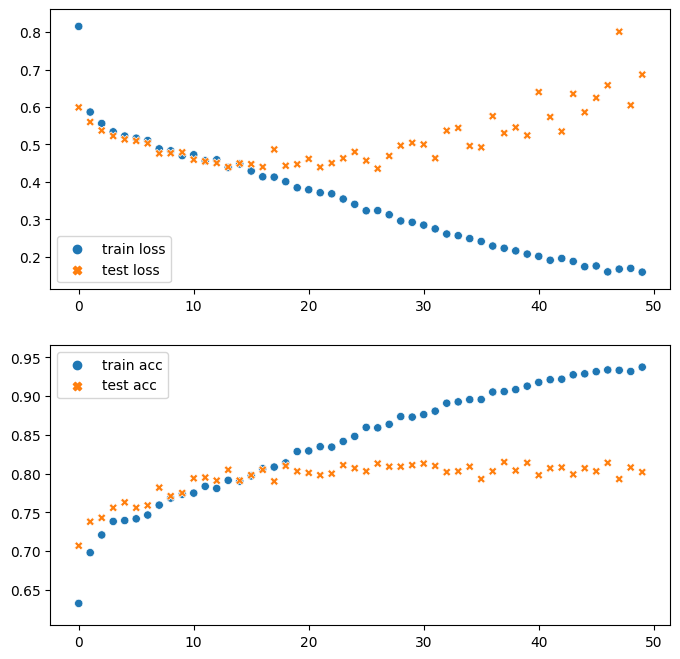

In [12]:
def plot():
    def get_cpu(tuples):
        new_his = []
        for t in tuples:
            new_his.append(t.cpu().item())
        return new_his

    ls = {"train loss":loss_tr_his,
          "test loss":loss_dev_his,
        #   "aux train loss": loss_aux_his
        }

    accs = {"train acc":acc_tr_his,
          "test acc":acc_dev_his,
        #   "aux train acc": acc_aux_his
        }
    plot_(ls, accs,  save =
          f"model/{prefix}/{len(acc_tr_his)}-{the_best['eval_acc']}.png")


plot()

In [13]:
print("best eval loss:", min(loss_dev_his))
print("best eval acc:", max(acc_dev_his))

print("best train loss:", min(loss_tr_his))
print("best train acc:", max(acc_tr_his))

best eval loss: 0.4354052424430847
best eval acc: 0.815
best train loss: 0.15921041035830086
best train acc: 0.9374127501163332
